This assignment is suggested to complete on Google colab  (https://colab.research.google.com/) to benefit from its GPU support. 

#### **Part 1: MLP**

Constructing and training a 3 layered neural network using Pytorch library for digit classification (MNIST)

In [ ]:
# required libraries and modules
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.utils
import time
import copy
import random
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold


# required libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.utils
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time

In [ ]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# download MNIST train and test sets using pytorch datasets module 
trans = transforms.ToTensor()

train_data = datasets.MNIST(root = '.data',train = True, download = True, transform = trans)

test_data = datasets.MNIST(root = '.data',train = False, download = True, transform = trans)

In [ ]:
# lets look train_data structure
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
# define a display function for sample images using matplotlib
def display_sampledata(img):
    # convert to numpy array ((C)hannelx(H)eightx(W)idth -> HxWxC )
    # plot image using matplotlib
    # TO-DO
    len_img = len(img)
    rimg = int(np.sqrt(len_img))
    cimg = int(np.sqrt(len_img))

    fig = plt.figure()
    size = rimg*cimg
    for i in range(size):
        ax = fig.add_subplot(rimg, cimg, i+1)
        plot = img[i].view(28, 28).cpu()
        ax.imshow(plot.numpy(), cmap = 'bone')
        ax.axis('off')



In [ ]:
# define a function for displaying the number of parameters
def get_netparams(net):
  # to-do
  count = (param.numel() for param in net.parameters() if param.requires_grad)
  return sum(count)



In [ ]:
# define a function that returns minibatch error in range [0,1]
def get_error(predicted_y, y):
    # to-do 
    # err =
    err = []     
    data = np.hstack((predicted_y, y)) 
    np.random.shuffle(data) 

    batch=100
    len_minib = data.shape[0] 
   
  
    for i in range(len_minib + 1): 
        minibatch = data[i * batch:(i + 1)*batch, :] 
        predminib = minibatch[:, :-1] 
        minibatch = minibatch[:, -1].reshape((-1, 1)) 
        Y_minib = minibatch
        err.append((pred_mini, Y_minib)) 

    check = data.shape[0] % batch
    if check != 0: 
        minibatch = data[i * batch:data.shape[0]] 
        predminib = minibatch[:, :-1] 
        minibatch = minibatch[:, -1].reshape((-1, 1)) 
        Y_minib = minibatch
        err.append((pred_mini, Y_minib)) 
    
    return err


In [ ]:
v_ratio = 0.9 # validation set taking 90% of the training set

len_train = int(len(train_data) * v_ratio)
len_valid = len(train_data) - len_train
train_data, valid_data = data.random_split(train_data, [len_train, len_valid])
print('train:',len(train_data))
print('validation:' ,len(valid_data))
print('test:', len(test_data))


train: 48600
validation: 5400
test: 10000


In [ ]:

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = trans

# define train and test data loaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, 
                                 shuffle = True, 
                                 batch_size = batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                 shuffle = True, 
                                 batch_size = batch_size)


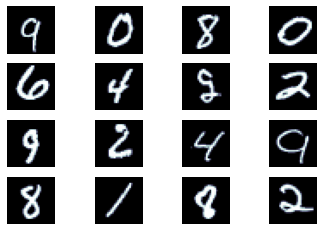

In [ ]:
# get some random 16 images
# to-do
len_img = 16
images = [image for image, label in [valid_data[i] for i in range(len_img)]] 

# show using your display_sampledata function
# to-do
display_sampledata(images)


In [ ]:
# Design a 3 layered  MLP network
class basicMLP(nn.Module):
  def __init__(self, input_size, num_hidden_neurons1,num_hidden_neurons2, num_classes):
    super(basicMLP,self).__init__()
    # define layers
    # to-do
    self.input_fc = nn.Linear(input_size, num_hidden_neurons1)
    self.hidden_fc = nn.Linear(num_hidden_neurons1, num_hidden_neurons2)
    self.output_fc = nn.Linear(num_hidden_neurons2, num_classes)
  
  def forward(self,input):    
    # define forward pass of your NN 
    # TO-DO
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.relu(self.input_fc(input))
    h_2 = F.relu(self.hidden_fc(h_1))
    y_pred = self.output_fc(h_2)
    return y_pred, h_2

In [ ]:
# create a 3 layered Neural Network instance for given parameters
# input size = image size * image size (get from your data shape)
# number of hidden neurons: 200 and 300
# number of classes: get from your data 

net = basicMLP(28*28,200,300,10)
print(net)

get_netparams(net)

basicMLP(
  (input_fc): Linear(in_features=784, out_features=200, bias=True)
  (hidden_fc): Linear(in_features=200, out_features=300, bias=True)
  (output_fc): Linear(in_features=300, out_features=10, bias=True)
)


220310

In [ ]:
# define cross entropy as loss function
# to-do
criterion = nn.CrossEntropyLoss()
# setup the SGD optimizer with learning rate=1.e-2  (also try Adam optimizer later)
# to-do
optimizerSGD = torch.optim.SGD(net.parameters(),lr = 1.e-2 )
net = net.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(net.parameters())


In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
# Train your model over 5 epochs (you can also try longer training)
n_epochs = 5
best_valid_loss = float('inf')
for epoch in range(n_epochs):
    
    epoch_loss = 0
    epoch_acc = 0
    
    net.train()
    
    for (x, y) in (train_loader):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = net(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        train_loss = epoch_loss / len(train_loader)
        train_acc =  epoch_acc / len(train_loader)

    epoch_loss = 0
    epoch_acc = 0
    
    net.eval()
    
    with torch.no_grad():
        
        for (images, labels) in valid_loader:

            images = images.to(device)
            labels = labels.to(device)

            y_pred, _ = net(images)

            loss = criterion(y_pred, labels)

            acc = calculate_accuracy(y_pred, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    valid_loss = epoch_loss / len(valid_loader)
    valid_acc = epoch_acc / len(valid_loader)

    if valid_loss < best_valid_loss:

      best_valid_loss = valid_loss
      torch.save(net.state_dict(), 'model.pt')

 

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start, end_time)
      
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Err: {(1-train_acc)}%')
    print('Accuracy=',train_acc*100)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    




Epoch: 01 | Epoch Time: 11m 53s
	Train Loss: 0.004 | Train Err: 0.001399183346901367%
Accuracy= 99.86008166530986
	 Val. Loss: 0.105 |  Val. Acc: 97.96%
Epoch: 02 | Epoch Time: 11m 58s
	Train Loss: 0.011 | Train Err: 0.0036008370266039647%
Accuracy= 99.63991629733961
	 Val. Loss: 0.130 |  Val. Acc: 97.54%
Epoch: 03 | Epoch Time: 12m 2s
	Train Loss: 0.010 | Train Err: 0.0030658566412121724%
Accuracy= 99.69341433587878
	 Val. Loss: 0.126 |  Val. Acc: 97.81%
Epoch: 04 | Epoch Time: 12m 7s
	Train Loss: 0.005 | Train Err: 0.0016872506328080572%
Accuracy= 99.8312749367192
	 Val. Loss: 0.116 |  Val. Acc: 97.98%
Epoch: 05 | Epoch Time: 12m 11s
	Train Loss: 0.008 | Train Err: 0.0024074176211416054%
Accuracy= 99.75925823788585
	 Val. Loss: 0.124 |  Val. Acc: 97.91%


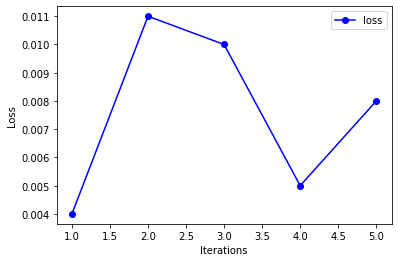

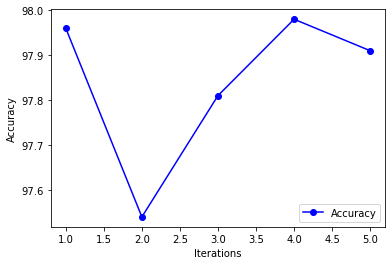

In [ ]:
#display training loss versus iterations plot
# to-do
size=[1,2,3,4,5]
loss=[0.004,0.011 ,0.010,0.005 ,0.008]
plt.plot(size,loss,'b-o',label='loss');
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


# display training accuracy versus iterations plot
# to-do
size=[1,2,3,4,5]
acc=[97.96,97.54,97.81,97.98,97.91]
plt.plot(size,acc,'b-o',label='Accuracy');
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#evaluate your NN model on test data
# variables for total test error
epoch_loss = 0
epoch_acc = 0
    
net.eval()
  
with torch.no_grad():
    
    for (images, labels) in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        y_pred, _ = net(images)

        loss = criterion(y_pred, labels)

        acc = calculate_accuracy(y_pred, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
test_loss = epoch_loss / len(test_loader) 
test_acc = epoch_acc / len(test_loader)
# compute test error and print it
print(f'Test error on test set: {1-test_acc}%')


Test error on test set: 0.021700032949447667%


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(net, test_loader, device)

pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)


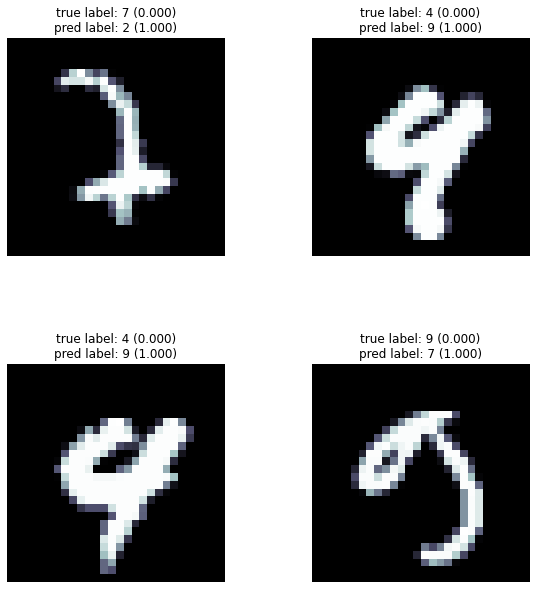

In [ ]:
# display 8 incorrect classified test samples with predicted labels using your display_sampledata function 
# to-do
n_images = 8
rows = int(np.sqrt(n_images))
cols = int(np.sqrt(n_images))

fig = plt.figure(figsize = (10, 10))
for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect_examples[i]
    true_prob = probs[true_label]
    incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
    ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
    ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                  f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
    ax.axis('off')
fig.subplots_adjust(hspace= 0.5)



